## Final Project (2.2) Malware classification with the Cuckoo sandbox
Made by: Marco Serenelli, Damiano Pasquini

# Libraries

In [23]:
import pandas as pd
import json
from json import JSONDecodeError
import os
from imblearn.over_sampling import SMOTE

In [24]:
# Ignore pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Create the dataset
Extraction of the data from the Cuckoo Sandbox report.json

In [25]:
# Read the json files and put them in a dataframe
DEFAULT_PATH = './analyses/'
REPORT_PATH = '/reports/report.json'

In [26]:
def extract_features(json_data):
    temp_row = pd.DataFrame(columns=['MD5', 'file_size', 'file_name', 'file_type', 'pe_imphash'])
    '''
        Target
        - File size (static)
        - File name (static)
        - File type (static)
        - File MD5 (static)
    '''
    try:
        temp_row.at[0, 'file_size'] = json_data['target']['file']['size']
        temp_row.at[0, 'file_name'] = json_data['target']['file']['name']
        temp_row.at[0, 'file_type'] = json_data['target']['file']['type']
        temp_row.at[0, 'MD5'] = json_data['target']['file']['md5']
    except KeyError:
        pass

    '''
        Static
        - Imported DLL (sequence)
        - Hash of the imported DLLs (static)
    '''
    # TODO; Maybe len?
    try:
        for imported_dll in json_data['static']['pe_imports']:
            temp_row[imported_dll['dll']] = 1
        temp_row.at[0, 'pe_imphash'] = json_data['static']['pe_imphash']
    except KeyError:
        pass
    # TODO; Maybe do AVG? and check if > threshold?
    #data.at[index, 'path_pe_section_entropy'] = json_data['static']['pe_section']['0']['entropy']

    '''
        Signatures
        - Signatures names (sequence)
    '''
    # TODO; binary or frequency encoding?
    try:
        for sig_names in json_data['signatures']:
            temp_row[sig_names['name']] = 1
    except KeyError:
        pass  

    '''
        Behavior
        - Files Created (sequence)
        - Files Written (sequence)
        - Regkeys Opened (sequence)
        - Regkeys Written (sequence)
        - Regkeys Read (sequence)
        - Generic process (sequence)
    }
    '''
    # TODO; Maybe first seen pattern?
    # TODO; Maybe regkeys can be identified by their group?
    try:
        for processes in json_data['behavior']['generic']:
            temp_row[processes['process_name']] = 1
        for file_created in json_data['behavior']['summary']['file_created']:
            temp_row[file_created] = 1
        for file_written in json_data['behavior']['summary']['file_written']:
            temp_row[file_written] = 1
        for regkey_opened in json_data['behavior']['summary']['regkey_opened']:
            temp_row[regkey_opened] = 1
        for regkey_written in json_data['behavior']['summary']['regkey_written']:
            temp_row[regkey_written] = 1
        for regkey_read in json_data['behavior']['summary']['regkey_read']:
            temp_row[regkey_read] = 1
    except KeyError:
        pass
    return temp_row

def extract_features_alternative(json_data):
    temp_row = pd.DataFrame(columns=['MD5', 'file_size', 'file_name', 'file_type', 'pe_imphash', 'path_pe_section_entropy'])
    '''
        Target
        - File size (static)
        - File name (static)
        - File type (static)
        - File MD5 (static)
    '''
    try:
        temp_row.at[0, 'file_size'] = json_data['target']['file']['size']
        temp_row.at[0, 'file_name'] = json_data['target']['file']['name']
        temp_row.at[0, 'file_type'] = json_data['target']['file']['type']
        temp_row.at[0, 'MD5'] = json_data['target']['file']['md5']
    except KeyError:
        pass

    '''
        Static
        - Imported DLL (sequence)
        - Hash of the imported DLLs (static)
    '''
    # TODO; Maybe len?
    try:
        for imported_dll in json_data['static']['pe_imports']:
            temp_row[imported_dll['dll']] = 1
        temp_row.at[0, 'pe_imphash'] = json_data['static']['pe_imphash']
        counter = 0
        average_antropy = 0
        for entropy_num in json_data['static']['pe_sections']:
            counter += 1
            average_antropy += entropy_num['entropy']
        temp_row.at[0, 'path_pe_section_entropy'] = average_antropy / counter
    except KeyError:
        pass
    # TODO; Maybe do AVG? and check if > threshold?
   
    #data.at[index, 'path_pe_section_entropy'] = json_data['static']['pe_section']['0']['entropy']

    '''
        Signatures
        - Signatures names (sequence)
    '''
    # TODO; binary or frequency encoding?
    try:
        counter = 0
        for sig_names in json_data['signatures']:
            #temp_row[sig_names['name']] = 1
            counter += 1
        temp_row.at[0, 'signatures_number'] = counter
    except KeyError:
        pass

    '''
        Behavior
        - Files Created (sequence)
        - Files Written (sequence)
        - Regkeys Opened (sequence)
        - Regkeys Written (sequence)
        - Regkeys Read (sequence)
        - Generic process (sequence)
    }
    '''
    # TODO; Maybe first seen pattern?
    # TODO; Maybe regkeys can be identified by their group?
    try:
        counter = 0
        for processes in json_data['behavior']['generic']:
            #temp_row[processes['process_name']] = 1
            counter += 1
        temp_row.at[0, 'generic_process_number'] = counter
        counter = 0
        for file_created in json_data['behavior']['summary']['file_created']:
            #temp_row[file_created] = 1
            counter += 1
        temp_row.at[0, 'file_created_number'] = counter
        counter = 0
        for file_written in json_data['behavior']['summary']['file_written']:
            #temp_row[file_written] = 1
            counter += 1
        temp_row.at[0, 'file_written_number'] = counter
        counter = 0
        for regkey_opened in json_data['behavior']['summary']['regkey_opened']:
            #temp_row[regkey_opened] = 1
            counter += 1
        temp_row.at[0, 'regkey_opened_number'] = counter
        counter = 0
        for regkey_written in json_data['behavior']['summary']['regkey_written']:
            #temp_row[regkey_written] = 1
            counter += 1
        temp_row.at[0, 'regkey_written_number'] = counter
        counter = 0
        for regkey_read in json_data['behavior']['summary']['regkey_read']:
            #temp_row[regkey_read] = 1
            counter += 1
        temp_row.at[0, 'regkey_read_number'] = counter
    except KeyError:
        pass

    return temp_row

def add_labels(df):
    df_labels = pd.read_csv('data/labeled_data_refactored.csv')
    return df.merge(df_labels[['MD5', 'label']], on='MD5', how='left')
    
def populate_dataset(df):
    # Look for all the json and extract dynamic features
    for _ , path_file in enumerate(sorted(os.listdir(DEFAULT_PATH), key=int)):
        with open(DEFAULT_PATH + path_file + REPORT_PATH) as json_file:
            try:
                #row = extract_features(json.load(json_file))
                row = extract_features_alternative(json.load(json_file))
                # Append the new row to the DataFrame
                df = pd.concat([df, row], ignore_index=True)                
            except JSONDecodeError:
                print("Error in file: " + json_file.name)
                continue
    
    df = add_labels(df)
    # Fill NaN with 0
    df = df.fillna(0)
    # Save the dataset
    if not os.path.exists('data'):
        os.makedirs('data')
    df.to_csv('data/dataset.csv', index=False)

def create_dataset():
    # Create the dataframe with static columns
    df = pd.DataFrame(columns=['MD5', 'file_size', 'file_name', 'file_type', 'pe_imphash'])
    populate_dataset(df)
    return df

In [27]:
dataset = create_dataset()

Error in file: ./analyses/49/reports/report.json
Error in file: ./analyses/52/reports/report.json
Error in file: ./analyses/65/reports/report.json
Error in file: ./analyses/68/reports/report.json
Error in file: ./analyses/73/reports/report.json
Error in file: ./analyses/85/reports/report.json
Error in file: ./analyses/107/reports/report.json
Error in file: ./analyses/147/reports/report.json
Error in file: ./analyses/207/reports/report.json
Error in file: ./analyses/296/reports/report.json
Error in file: ./analyses/302/reports/report.json


# Plotting Utilities

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot dataset to check for imbalanced classes
def plot_dataset(df, title):
    class_distribution = df['label'].value_counts()
    print(class_distribution)
    plt.figure(figsize=(8, 6))
    plt.bar(class_distribution.index, class_distribution.values)
    plt.title('Class Distribution of ' + title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45)
    if not os.path.exists("results/class_distribution"):
        os.makedirs("results/class_distribution")
    plt.savefig('results/class_distribution/'+ title + '.png')
    plt.show()

def plot_confusion_matrix(exp, pred, classifier_name, feature_names, scaler):
    cm = confusion_matrix(exp, pred, labels=feature_names)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=feature_names, yticklabels=feature_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {classifier_name}, Scaler = {scaler}')
    plt.tight_layout()
    if scaler:
        if not os.path.exists("results/confusion_matrix_scaled"):
            os.makedirs("results/confusion_matrix_scaled")
        plt.savefig('results/confusion_matrix_scaled/'+ classifier_name +'.png')
    else:
        if not os.path.exists("results/confusion_matrix"):
            os.makedirs("results/confusion_matrix")
        plt.savefig('results/confusion_matrix/'+ classifier_name +'.png')
    plt.show()

# Create ML models
Fit models using Recursive Feature Elimination (RFE)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from joblib import dump, load
from imblearn.over_sampling import ADASYN

In [31]:

def one_hot_encoding(df):
    categorical_columns = ['file_name', 'file_type', 'pe_imphash', 'file_size', 'MD5']
    df_encoded = pd.get_dummies(df, columns=categorical_columns)
    df_encoded.to_csv('data/dataset_encoded.csv', index=False)
    return df_encoded

def resampling(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

DATASET_PATH = 'data/dataset.csv'
def load_data():
    df = pd.read_csv(DATASET_PATH)
    plot_dataset(df, 'Dataset_complete')
    # Remove rows where labels there is 'Unknown'?
    df = df[df.label != 'adware']
    df = df[df.label != 'downloader']
    df = df[df.label != 'banker']
    df = df[df.label != 'fakeav']
    df = df[df.label != 'phishing']
    df = df[df.label != 'dropper']
    df = df[df.label != 'hacktool']
    plot_dataset(df, 'Dataset_trimmed')
    # one hot encode categorical data
    df = one_hot_encoding(df)
    # encode y
    df.to_csv('data/dataset_encoded.csv', index=False)
    # Take the y
    y = df['label']
    # Take the X
    X = df.drop(['label'], axis=1)
    # divide train (70%), test (30%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    #X_train, y_train = resampling(X_train, y_train)
    return X_train, X_test, y_train, y_test

In [32]:
# All classifiers
classifier_functions = {
    "naive_bayes": MultinomialNB,
    "knn": KNeighborsClassifier,
    "logistic_regression": lambda: LogisticRegression(max_iter=1000),
    "random_forest": RandomForestClassifier,
    "decision_tree": DecisionTreeClassifier
}

label
Unknown       162
trojan         86
worm           53
ransomware     33
virus          27
pua            13
dropper         7
hacktool        5
adware          2
downloader      1
banker          1
fakeav          1
phishing        1
Name: count, dtype: int64


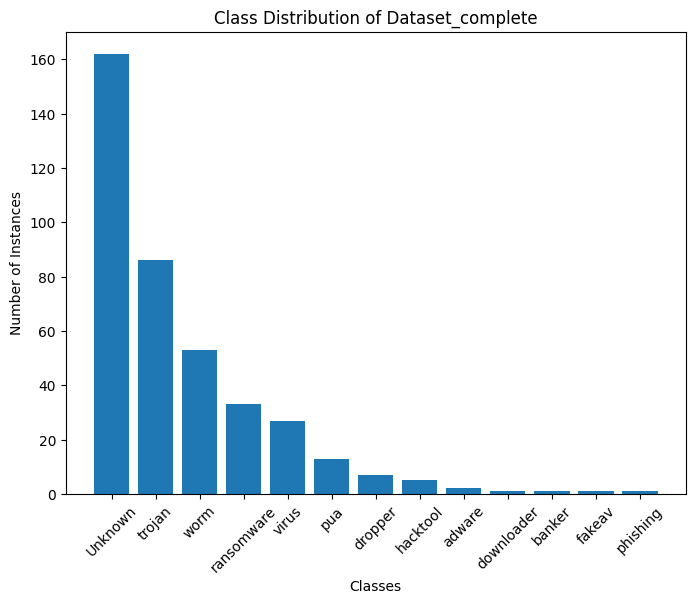

label
Unknown       162
trojan         86
worm           53
ransomware     33
virus          27
pua            13
Name: count, dtype: int64


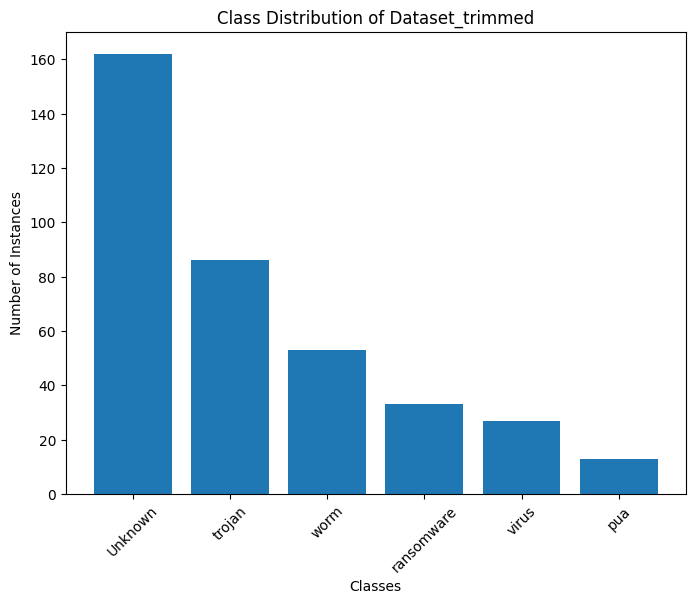

Classification report for naive_bayes on train data:
              precision    recall  f1-score   support

     Unknown       0.31      0.04      0.08       117
         pua       1.00      0.11      0.20         9
  ransomware       0.44      0.32      0.37        22
      trojan       0.57      0.07      0.12        59
       virus       0.10      0.84      0.18        19
        worm       0.48      0.80      0.60        35

    accuracy                           0.23       261
   macro avg       0.48      0.36      0.26       261
weighted avg       0.41      0.23      0.19       261



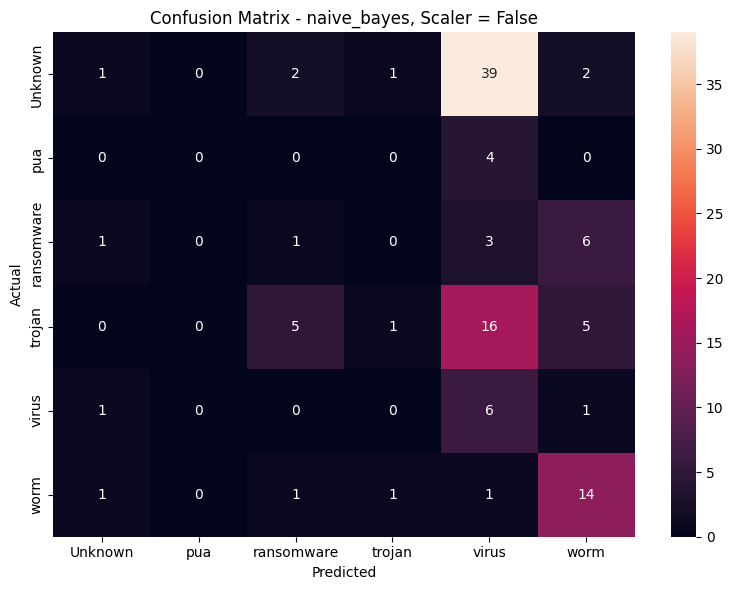

F1 Score macro average: 0.16200380020255797
Classification report for knn on train data:
              precision    recall  f1-score   support

     Unknown       0.68      0.91      0.78       117
         pua       0.40      0.67      0.50         9
  ransomware       0.33      0.23      0.27        22
      trojan       0.51      0.36      0.42        59
       virus       0.00      0.00      0.00        19
        worm       0.64      0.60      0.62        35

    accuracy                           0.61       261
   macro avg       0.43      0.46      0.43       261
weighted avg       0.55      0.61      0.57       261



/Users/marcoserenelli/Desktop/MCCukoo/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcoserenelli/Desktop/MCCukoo/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcoserenelli/Desktop/MCCukoo/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

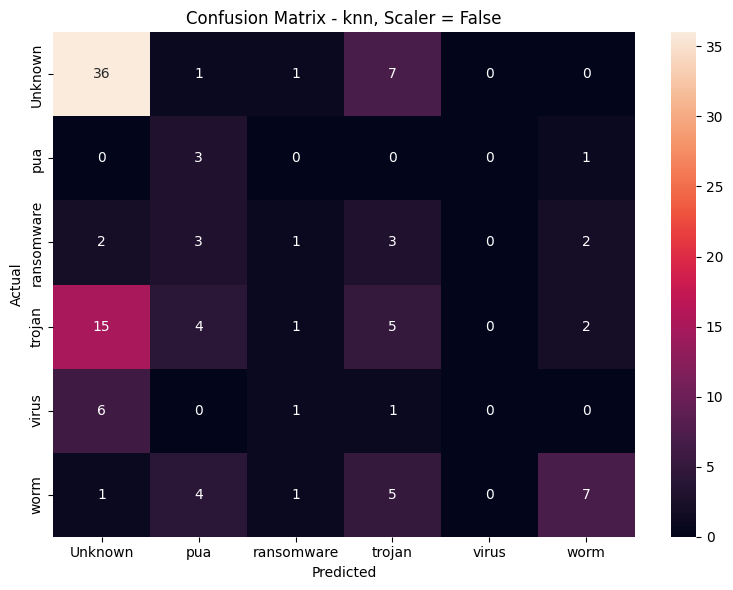

F1 Score macro average: 0.30025062656641605


/Users/marcoserenelli/Desktop/MCCukoo/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for logistic_regression on train data:
              precision    recall  f1-score   support

     Unknown       0.76      0.99      0.86       117
         pua       0.89      0.89      0.89         9
  ransomware       1.00      0.86      0.93        22
      trojan       0.93      0.69      0.80        59
       virus       1.00      0.16      0.27        19
        worm       0.97      0.94      0.96        35

    accuracy                           0.84       261
   macro avg       0.93      0.76      0.78       261
weighted avg       0.87      0.84      0.82       261



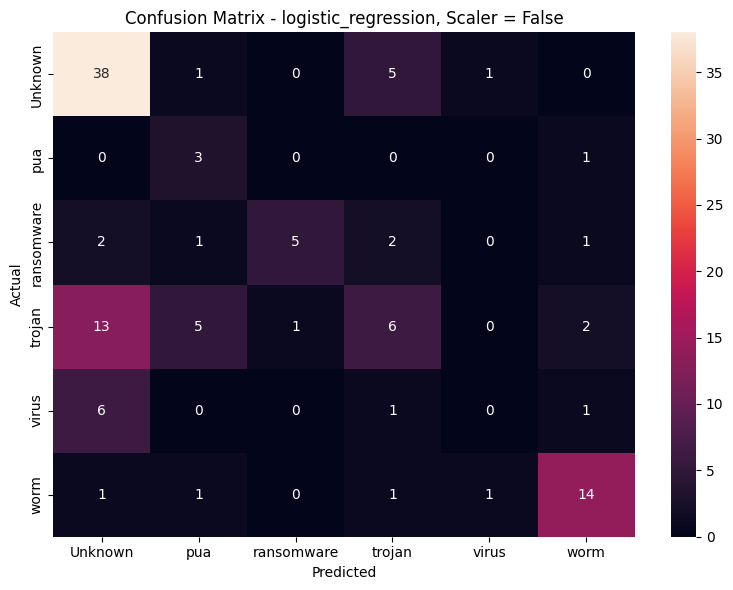

F1 Score macro average: 0.4590859767330355


AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [33]:
def train_classifier(train_data, train_label, test_data, test_label, classifier, classifier_name, feature_names, scaler):
    classifier.fit(train_data, train_label)
    # Plot train classification report    
    y_pred = classifier.predict(train_data)
    print(f"Classification report for {classifier_name} on train data:")
    print(classification_report(train_label, y_pred, target_names=feature_names))
    # Predict the labels of the test set
    y_pred = classifier.predict(test_data)
    plot_confusion_matrix(test_label, y_pred, classifier_name, feature_names, scaler)
    score = f1_score(test_label, y_pred, average='macro')
    print(f'F1 Score macro average: {score}')
    return classifier, score

# Find the best score among all
def find_best_score(train_data, train_label, test_data, test_label, feature_names, cl = None, cl_name = None, cl_f1 = 0, scaler = False):
    score = 0
    best_f1 = cl_f1
    best_classifier_name = cl_name
    best_classifier = cl
    is_best_scaled = False
    for classifier_name in classifier_functions:
        classifier_ret, score = train_classifier(train_data, train_label, test_data, test_label, classifier_functions[classifier_name](), classifier_name, feature_names, scaler)
        if score > best_f1:
            best_f1 = score
            best_classifier = classifier_ret
            best_classifier_name = classifier_name
            is_best_scaled = scaler
    return best_classifier, best_classifier_name, best_f1, is_best_scaled

# Find the best classifier 
def find_best_classifier():
    x_train, x_test, y_train, y_test = load_data()
    feature_names = np.unique(y_train)
    cl, cl_name, cl_f1, scaled = find_best_score(x_train, y_train, x_test, y_test, feature_names)
    print(f"Best classifier is {cl_name} with scaling: {scaled} and F1 {cl_f1}")
    return cl, cl_name, cl_f1

classifier, classifier_name, classifier_f1 = find_best_classifier()